In [35]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
os.chdir("/home/zongchen/thinned_mfld")

import sys
sys.path.append("/home/zongchen/thinned_mfld")
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

from tqdm import tqdm

plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 18
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')

# plt.rc('font', family='Arial', size=12)
plt.rc('axes', titlesize=22, labelsize=22, grid=True)
plt.rc('lines', linewidth=2)
plt.rc('legend', fontsize=22, frameon=False)
plt.rc('xtick', labelsize=18, direction='in')
plt.rc('ytick', labelsize=18, direction='in')
plt.rc('figure', figsize=(6, 4), dpi=100)

In [ ]:
particle_num = 64
loading_freq = 2
seed_list = [0, 1, 2]
methods_list = ['random', 'false', 'kt']
bandwidth = 1.0
g = 0
dataset = 'covertype'

train_loss_trajectory_dict = {'kt': [], 'random': [], 'false': []}
test_loss_trajectory_dict = {'kt': [], 'random': [], 'false': []}
mmd_dict = {'kt': [], 'random': [], 'false': []}
thin_original_mse_dict = {'kt': [], 'random': [], 'false': []}


for method in methods_list:
    for seed in seed_list:
        if method == 'false' or method == 'random':
            dir = f"./results/neural_network_covertype/thinning_{method}/kernel_sobolev__step_size_0.1__bandwidth_1.0"
            dir += f"__step_num_3000__g_0__particle_num_{particle_num}__noise_scale_0.001__seed_{seed}__complete"
        else:
            dir = f"./results/neural_network_boston/thinning_{method}/kernel_gaussian__step_size_0.1__bandwidth_{bandwidth}"
            dir += f"__step_num_3000__g_{g}__particle_num_{particle_num}__noise_scale_0.001__seed_{seed}__complete"
        train_loss_trajectory = jnp.load(f"{dir}/train_losses.npy")
        test_loss_trajectory = jnp.load(f"{dir}/test_losses.npy")
        mmd_trajectory = jnp.load(f"{dir}/mmd_path.npy")
        thin_original_mse = jnp.load(f"{dir}/thin_original_mse_path.npy")

        if seed == 0:
            train_loss_trajectory_dict[method] = train_loss_trajectory[:, None]
            test_loss_trajectory_dict[method] = test_loss_trajectory[:, None]
            mmd_dict[method] = mmd_trajectory[:, None][::loading_freq]
            thin_original_mse_dict[method] = thin_original_mse[:, None][::loading_freq]
        else:
            train_loss_trajectory_dict[method] = jnp.concatenate([train_loss_trajectory_dict[method], train_loss_trajectory[:, None]], axis=1)
            test_loss_trajectory_dict[method] = jnp.concatenate([test_loss_trajectory_dict[method], test_loss_trajectory[:, None]], axis=1)
            mmd_dict[method] = jnp.concatenate([mmd_dict[method], mmd_trajectory[:, None][::loading_freq]], axis=1)
            thin_original_mse_dict[method] = jnp.concatenate([thin_original_mse_dict[method], thin_original_mse[:, None][::loading_freq]], axis=1)


In [37]:
train_loss_trajectory_dict_mean = {'kt': [], 'random': [], 'false': []}
test_loss_trajectory_dict_mean = {'kt': [], 'random': [], 'false': []}
train_loss_trajectory_dict_ste = {'kt': [], 'random': [], 'false': []}
test_loss_trajectory_dict_ste = {'kt': [], 'random': [], 'false': []}
mmd_dict_mean = {'kt': [], 'random': [], 'false': []}
mmd_dict_ste = {'kt': [], 'random': [], 'false': []}
thin_original_mse_dict_mean = {'kt': [], 'random': [], 'false': []}
thin_original_mse_dict_ste = {'kt': [], 'random': [], 'false': []}

for method in methods_list:
    train_loss_trajectory_dict_mean[method] = np.nanmean(train_loss_trajectory_dict[method], axis=1)
    test_loss_trajectory_dict_mean[method] = np.nanmean(test_loss_trajectory_dict[method], axis=1)
    train_loss_trajectory_dict_ste[method] = np.nanstd(train_loss_trajectory_dict[method], axis=1) / np.sqrt(train_loss_trajectory_dict[method].shape[1])
    test_loss_trajectory_dict_ste[method] = np.nanstd(test_loss_trajectory_dict[method], axis=1) / np.sqrt(test_loss_trajectory_dict[method].shape[1])
    mmd_dict_mean[method] = np.nanmean(mmd_dict[method], axis=1)
    mmd_dict_ste[method] = np.nanstd(mmd_dict[method], axis=1) / np.sqrt(mmd_dict[method].shape[1])
    thin_original_mse_dict_mean[method] = np.nanmean(thin_original_mse_dict[method], axis=1)
    thin_original_mse_dict_ste[method] = np.nanstd(thin_original_mse_dict[method], axis=1) / np.sqrt(thin_original_mse_dict[method].shape[1])   



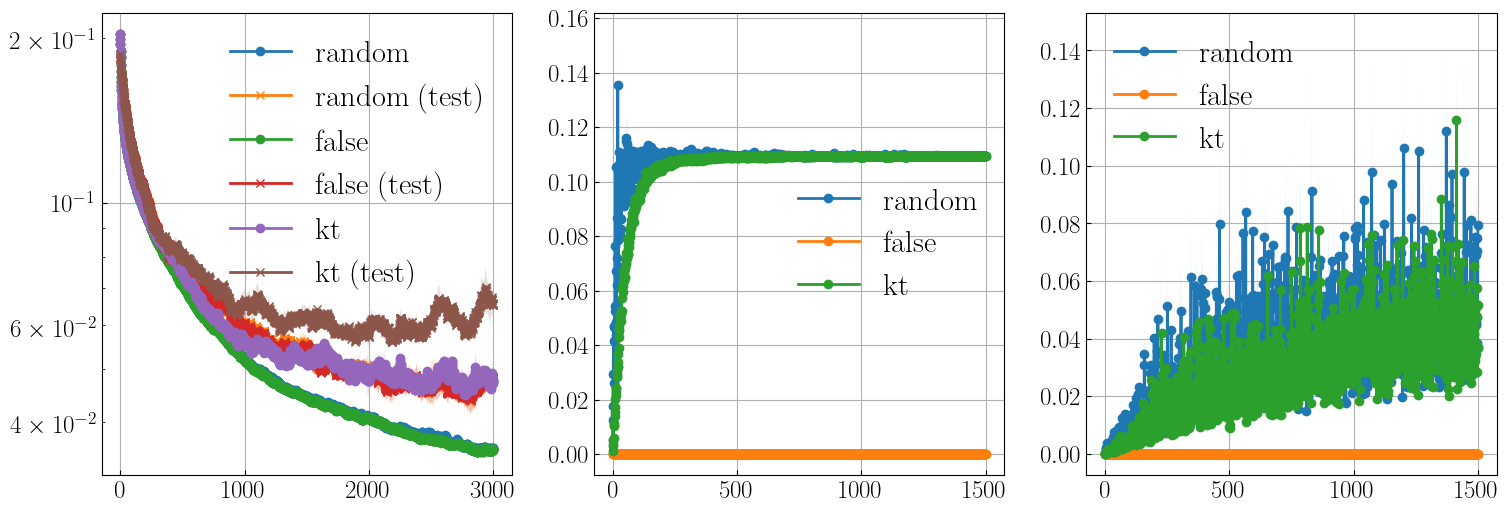

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].grid(True)

for method in methods_list:
    axs[0].plot(jnp.arange(train_loss_trajectory_dict_mean[method].shape[0]), train_loss_trajectory_dict_mean[method], label=method, marker='o')
    axs[0].fill_between(jnp.arange(train_loss_trajectory_dict_mean[method].shape[0]), train_loss_trajectory_dict_mean[method] - train_loss_trajectory_dict_ste[method], 
                        train_loss_trajectory_dict_mean[method] + train_loss_trajectory_dict_ste[method], alpha=0.2)
    axs[0].plot(jnp.arange(test_loss_trajectory_dict_mean[method].shape[0]), test_loss_trajectory_dict_mean[method], label=method + ' (test)', marker='x')
    axs[0].fill_between(jnp.arange(test_loss_trajectory_dict_mean[method].shape[0]), test_loss_trajectory_dict_mean[method] - test_loss_trajectory_dict_ste[method], 
                        test_loss_trajectory_dict_mean[method] + test_loss_trajectory_dict_ste[method], alpha=0.2)
    axs[0].legend()
    axs[0].set_yscale('log')

for method in methods_list:
    axs[1].plot(jnp.arange(mmd_dict_mean[method].shape[0]), mmd_dict_mean[method], label=method, marker='o')
    axs[1].fill_between(jnp.arange(mmd_dict_mean[method].shape[0]), mmd_dict_mean[method] - mmd_dict_ste[method], 
                        mmd_dict_mean[method] + mmd_dict_ste[method], alpha=0.2)
    axs[1].legend()

for method in methods_list:
    axs[2].plot(jnp.arange(thin_original_mse_dict_mean[method].shape[0]), thin_original_mse_dict_mean[method], label=method, marker='o')
    axs[2].fill_between(jnp.arange(thin_original_mse_dict_mean[method].shape[0]), thin_original_mse_dict_mean[method] - thin_original_mse_dict_ste[method], 
                        thin_original_mse_dict_mean[method] + thin_original_mse_dict_ste[method], alpha=0.2)
    axs[2].legend()
plt.show()


In [39]:
test_loss_trajectory_dict_mean['kt'][-1]

np.float64(0.0654547746020974)

In [40]:
test_loss_trajectory_dict_mean['false'][-1]

np.float64(0.04771767388828721)

In [41]:
test_loss_trajectory_dict_mean['random'][-1]

np.float64(0.047260617783849296)